In [1]:
from Data import *

import pandas as pd
import string
import random

import torch
from torch import optim
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.utils.rnn import  pack_padded_sequence, pad_packed_sequence
from torchsummary import summary

import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import numpy as np
import tqdm
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_name = 'Lab4_seq2seq_vae_gru.pt'
print('Using {} device'.format(device))

Using cuda device


In [2]:
sp = 0
tp = 1
pg = 2
p = 3

def split_data(data):
    split_data = []
    for string in data:
        split_space = string.split()
        for i, word in enumerate(split_space):
            split_data.append(word)
    return split_data

def y_train_make(n):
    np_sp = np.array([sp])
    np_tp = np.array([tp])
    np_pg = np.array([pg])
    np_p = np.array([p])
    y = []
    for i in range(n):
        y.append(np_sp)
        y.append(np_tp)
        y.append(np_pg)
        y.append(np_p)
    return np.array(y)

def src_trg_split(data):
    src = []
    trg = []
    for i in range(0, len(data), 2):
        src.append(data[i])
        trg.append(data[i])
    return np.array(src), np.array(trg)

In [3]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

train_data = np.squeeze(pd.read_csv('train.txt', header=None))
y_train = y_train_make(len(train_data))

train_data = split_data(train_data)

vocab = Vocabulary()
vocab.build_vocab(train_data)

train_loader = DataTransformer(train_data, use_cuda=True)

In [4]:
test_data = np.squeeze(pd.read_csv('test.txt', header=None))
test_data = split_data(test_data)
test_data = np.array(test_data)
src, trg = src_trg_split(test_data)
test_src = []
test_trg = []

for word in src:
    test_src.append(train_loader.vocab.sequence_to_indices(word, add_eos=True))

for word in trg:
    test_trg.append(train_loader.vocab.sequence_to_indices(word, add_eos=True))
"""
sp -> p
sp -> pg
sp -> tp
sp -> tp
p  -> tp
sp -> pg
p  -> sp
pg -> sp
pg -> p
pg -> tp
"""
test_c_src = np.array([sp, sp, sp, sp, p, sp, p, pg, pg, pg]).reshape(-1, 1)
test_c_trg = np.array([p, pg, tp, tp, tp, pg, sp, sp, p, tp]).reshape(-1, 1)
test_c_src = torch.tensor(test_c_src).to(device)
test_c_trg = torch.tensor(test_c_trg).to(device)

In [5]:
def test_eval(model, epoch):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():    
        src_c = test_src
        trg_c = test_trg
        optimizer.zero_grad()            
        output = model(src, trg, src_c, trg_c, 0) #turn off teacher forcing
        loss = criterion(output[1:].view(-1, output.shape[-1]), trg[1:].view(-1))
        
        if epoch % 10 == 0:
            print("=========show testing result=========")
            for i in range(output.shape[-1]):
                show_result(trg, output, i)
                print()
            
        return loss
    
def show_result(target, output, index):
    print("Ground true: ", end="")
    for i in range(max_len):
        tmp = trg[index, i]
        if tmp == 1:
            break
        elif tmp == 0:
            continue
        print(chr(trg[index, i]-7+ord('a')), end="")
    
    print(" Predict: ", end="")
    for i in range(max_len):
        print(chr(np.argmax(o[index, i, 3:])-4+ord('a')), end="")

In [6]:
class Encoder(nn.Module):

    def __init__(self, vocab_size, embedding_size, output_size, lat_dim):
        """Define layers for a vanilla rnn encoder"""
        super(Encoder, self).__init__()

        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.gru = nn.GRU(embedding_size, output_size)
        
        self.hidden2mean = nn.Linear(output_size, lat_dim)
        self.hidden2logv = nn.Linear(output_size, lat_dim)

    def forward(self, input_seqs, input_lengths, hidden=None):
        embedded = self.embedding(input_seqs)
        packed = pack_padded_sequence(embedded, input_lengths)
        packed_outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = pad_packed_sequence(packed_outputs)
        
        means = self.hidden2mean(hidden)
        logv = self.hidden2logv(hidden)
        
        return outputs, means, logv

In [7]:
class Decoder(nn.Module):

    def __init__(self, hidden_size, output_size, lat_dim, max_length, teacher_forcing_ratio, sos_id, use_cuda):
        """Define layers for a vanilla rnn decoder"""
        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.latent2hidden = nn.Linear(lat_dim, hidden_size)
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.log_softmax = nn.LogSoftmax(dim=-1)  # work with NLLLoss = CrossEntropyLoss

        self.max_length = max_length
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.sos_id = sos_id
        self.use_cuda = use_cuda

    def forward_step(self, inputs, hidden):
        # inputs: (time_steps=1, batch_size)
        batch_size = inputs.size(1)
        embedded = self.embedding(inputs)
        embedded.view(1, batch_size, self.hidden_size)  # S = T(1) x B x N
        rnn_output, hidden = self.gru(embedded, hidden)  # S = T(1) x B x H
        rnn_output = rnn_output.squeeze(0)  # squeeze the time dimension
        output = self.log_softmax(self.out(rnn_output))  # S = B x O
        return output, hidden

    def forward(self, context_vector, targets):

        # Prepare variable for decoder on time_step_0
        target_vars, target_lengths = targets
        batch_size = context_vector.size(1)
        decoder_input = Variable(torch.LongTensor([[self.sos_id] * batch_size]))

        # Pass the context vector
        decoder_hidden = context_vector

        max_target_length = max(target_lengths)
        decoder_outputs = Variable(torch.zeros(
            max_target_length,
            batch_size,
            self.output_size
        ))  # (time_steps, batch_size, vocab_size)

        if self.use_cuda:
            decoder_input = decoder_input.cuda()
            decoder_outputs = decoder_outputs.cuda()

        use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False

        # Unfold the decoder RNN on the time dimension
        for t in range(max_target_length):
            decoder_outputs_on_t, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs[t] = decoder_outputs_on_t
            if use_teacher_forcing:
                decoder_input = target_vars[t].unsqueeze(0)
            else:
                decoder_input = self._decode_to_index(decoder_outputs_on_t)

        return decoder_outputs, decoder_hidden

    def evaluate(self, context_vector):
        batch_size = context_vector.size(1) # get the batch size
        decoder_input = Variable(torch.LongTensor([[self.sos_id] * batch_size]))
        decoder_hidden = context_vector

        decoder_outputs = Variable(torch.zeros(
            self.max_length,
            batch_size,
            self.output_size
        ))  # (time_steps, batch_size, vocab_size)

        if self.use_cuda:
            decoder_input = decoder_input.cuda()
            decoder_outputs = decoder_outputs.cuda()

        # Unfold the decoder RNN on the time dimension
        for t in range(self.max_length):
            decoder_outputs_on_t, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs[t] = decoder_outputs_on_t
            decoder_input = self._decode_to_index(decoder_outputs_on_t)  # select the former output as input

        return self._decode_to_indices(decoder_outputs)

    def _decode_to_index(self, decoder_output):
        """
        evaluate on the logits, get the index of top1
        :param decoder_output: S = B x V or T x V
        """
        value, index = torch.topk(decoder_output, 1)
        index = index.transpose(0, 1)  # S = 1 x B, 1 is the index of top1 class
        if self.use_cuda:
            index = index.cuda()
        return index

    def _decode_to_indices(self, decoder_outputs):
        """
        Evaluate on the decoder outputs(logits), find the top 1 indices.
        Please confirm that the model is on evaluation mode if dropout/batch_norm layers have been added
        :param decoder_outputs: the output sequence from decoder, shape = T x B x V 
        """
        decoded_indices = []
        batch_size = decoder_outputs.size(1)
        decoder_outputs = decoder_outputs.transpose(0, 1)  # S = B x T x V

        for b in range(batch_size):
            top_ids = self._decode_to_index(decoder_outputs[b])
            decoded_indices.append(top_ids.data[0].cpu().numpy())
        return decoded_indices

In [8]:
class Seq2Seq(nn.Module):

    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, inputs, targets):
        input_vars, input_lengths = inputs
        encoder_outputs, encoder_means, encoder_logv = self.encoder.forward(input_vars, input_lengths)       
        encoder_hidden = self.reparaterization_trick(encoder_means, encoder_logv)
        encoder_hidden = self.decoder.latent2hidden(encoder_hidden)
        decoder_outputs, decoder_hidden = self.decoder.forward(context_vector=encoder_hidden, targets=targets)
        return decoder_outputs, decoder_hidden, encoder_means, encoder_logv

    def evaluate(self, inputs):
        input_vars, input_lengths = inputs
        encoder_outputs, encoder_means, encoder_logv = self.encoder(input_vars, input_lengths)
        encoder_hidden = self.reparaterization_trick(encoder_means, encoder_logv)
        encoder_hidden = self.decoder.latent2hidden(encoder_hidden)
        decoded_sentence = self.decoder.evaluate(context_vector=encoder_hidden)
        return decoded_sentence
    
    def reparaterization_trick(self, mean, logv):
        std = torch.exp(0.5*logv)
        eps = torch.randn_like(std)
        return  mean + eps * std

In [9]:
class Trainer(object):

    def __init__(self, model, data_transformer, learning_rate, use_cuda, checkpoint_name,
                 teacher_forcing_ratio=1.0, kl_weight=0):

        self.model = model
        self.checkpoint_name = checkpoint_name
        self.total_iter = 0
        
        # save list
        self.entropy = []
        self.kld = []
        self.kl_weight_list = []
        self.teacher_forcing_ratio_list = []
        self.score = []
        
        # init hyperparameters
        self.kl_weight = kl_weight
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.kl_weight_list.append(self.kl_weight)
        self.teacher_forcing_ratio_list.append(self.teacher_forcing_ratio)
        
        # record some information about dataset
        self.data_transformer = data_transformer
        self.vocab_size = self.data_transformer.vocab_size
        self.PAD_ID = self.data_transformer.PAD_ID
        self.use_cuda = use_cuda
        
        # optimizer setting
        self.learning_rate = learning_rate
        self.optimizer= torch.optim.Adam(self.model.parameters(), lr=learning_rate)
#         self.optimizer= torch.optim.SGD(self.model.parameters(), lr=learning_rate)
        self.criterion = torch.nn.NLLLoss(ignore_index=self.PAD_ID, reduction='mean')

    def train(self, num_epochs, batch_size, pretrained=False):

        if pretrained:
            self.load_model()

        step = 0

        for epoch in range(0, num_epochs):
            mini_batches = self.data_transformer.mini_batches(batch_size=batch_size)
            for input_batch, target_batch in mini_batches:
                self.total_iter += 1
                self.optimizer.zero_grad()
                self.model.decoder.teacher_forcing_ratio = self.teacher_forcing_ratio
                decoder_outputs, decoder_hidden, encoder_means, encoder_logv = self.model(input_batch, target_batch)

                # calculate the loss and back prop.
                cur_loss = self.get_loss(decoder_outputs, target_batch[0])
                kl_loss = self.kl_weight * self.get_kl_loss(encoder_means, encoder_logv)
                loss = cur_loss + kl_loss
                
                self.entropy.append(cur_loss.item())
                self.kld.append(kl_loss.item())
                
                # logging
                step += 1
                if step % 50 == 0:
                    print("Step:", step, "char-loss: ", loss.item())
                    print("KL_weight: ", self.kl_weight, "teacher_forcing_ratio: ", self.teacher_forcing_ratio)
                    self.save_model()
                loss.backward()

                # optimize
                self.optimizer.step()
                
                # update hyperparameters
                self.kl_weight = self.get_kl_weight(self.kl_weight)
                self.teacher_forcing_ratio = self.get_teacher_forcing_ratio(self.teacher_forcing_ratio)
                self.kl_weight_list.append(self.kl_weight)
                self.teacher_forcing_ratio_list.append(self.teacher_forcing_ratio)

        self.save_model()

    def get_loss(self, decoder_outputs, targets):
        b = decoder_outputs.size(1)
        t = decoder_outputs.size(0)
        targets = targets.contiguous().view(-1)  # S = (B*T)
        decoder_outputs = decoder_outputs.view(b * t, -1)  # S = (B*T) x V
        return self.criterion(decoder_outputs, targets)
    
    def get_kl_loss(self, mean, logvar):
        result = -0.5 * torch.sum(logvar - torch.pow(mean, 2) - torch.exp(logvar) + 1, 1)
        return result.mean()
    
    def get_kl_weight(self, kl_weight):
#         if self.total_iter < 100000:
#             return 0
#         else:
#             return min(1, kl_weight + 0.00001)
        return min(1, kl_weight + 0.0000001)

    def get_teacher_forcing_ratio(self, teacher_forcing_ratio):
#         if self.total_iter < 10000:
#             return 1.0
#         else:
        return max(0, teacher_forcing_ratio - 0.0000001)
#         return 1

    def save_model(self):
        torch.save(self.model.state_dict(), self.checkpoint_name)
        np.savez('loss.npz', entropy=self.entropy, kld=self.kld, kl_weight=self.kl_weight_list,\
                 teacher_forcing_ratio=self.teacher_forcing_ratio_list, score=self.score)
        print("Model has been saved as %s.\n" % self.checkpoint_name)

    def load_model(self):
        self.model.load_state_dict(torch.load(self.checkpoint_name, map_location=device))
        print("Pretrained model has been loaded.\n")

    def evaluate(self, words):
        # make sure that words is list
        if type(words) is not list:
            words = [words]

        # transform word to index-sequence
        eval_var = self.data_transformer.evaluation_batch(words=words)
        decoded_indices = self.model.evaluate(eval_var)
        results = []
        for indices in decoded_indices:
            results.append(self.data_transformer.vocab.indices_to_sequence(indices))
        return results
    
    def compute_bleu(self, output, reference):
        cc = SmoothingFunction()
        if len(reference) == 3:
            weights = (0.33,0.33,0.33)
        else:
            weights = (0.25,0.25,0.25,0.25)
        return sentence_bleu([reference], output,weights=weights,smoothing_function=cc.method1)

In [10]:
# define our models
encoder = Encoder(vocab_size=train_loader.vocab_size,
                         embedding_size=256,
                         output_size=256,
                         lat_dim=32).to(device)

decoder = Decoder(hidden_size=256,
                         output_size=train_loader.vocab_size,
                         lat_dim=32,
                         max_length=train_loader.max_length,
                         teacher_forcing_ratio=1.,
                         sos_id=train_loader.SOS_ID,
                         use_cuda=True).to(device)

seq2seq = Seq2Seq(encoder=encoder,
                  decoder=decoder)

trainer = Trainer(seq2seq, train_loader, learning_rate=0.001, use_cuda=True, checkpoint_name=checkpoint_name)

for epoch in tqdm.notebook.tqdm(range(100)):
    trainer.train(num_epochs=10, batch_size=128, pretrained=False)
    
    ## eval
    print("======================Evaluating======================")  
    total_score = 0.0
    for src in test_src:
        word = vocab.indices_to_sequence(src)
        results = trainer.evaluate(word)[0]
        score = trainer.compute_bleu(results, word)
        print("True: {:>12}".format(word), "\tPredict: {:>12}".format(results), "\tScore: {:>8.5f}".format(score))
        total_score += score
    total_score /= len(test_src)
    trainer.score.append(total_score)
    print("======================================================\n")

Step: 50 char-loss:  1.7852681875228882
KL_weight:  4.899999999999996e-06 teacher_forcing_ratio:  0.9999951000000026
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 100 char-loss:  1.1767622232437134
KL_weight:  9.90000000000001e-06 teacher_forcing_ratio:  0.9999901000000052
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 150 char-loss:  0.8408409357070923
KL_weight:  1.4900000000000047e-05 teacher_forcing_ratio:  0.9999851000000078
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 200 char-loss:  0.5223073959350586
KL_weight:  1.9900000000000006e-05 teacher_forcing_ratio:  0.9999801000000105
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 250 char-loss:  0.40802472829818726
KL_weight:  2.4899999999999958e-05 teacher_forcing_ratio:  0.9999751000000131
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 300 char-loss:  0.287710964679718
KL_weight:  2.989999999999991e-05 teacher_forcing_ratio:  0.9999701000000157
Model has been saved as Lab4_seq2seq_vae_

Step: 200 char-loss:  0.07126442342996597
KL_weight:  0.00017590000000000344 teacher_forcing_ratio:  0.9998241000000926
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 250 char-loss:  0.0701124370098114
KL_weight:  0.00018090000000000356 teacher_forcing_ratio:  0.9998191000000952
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 300 char-loss:  0.08587560802698135
KL_weight:  0.00018590000000000368 teacher_forcing_ratio:  0.9998141000000978
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 350 char-loss:  0.06730353832244873
KL_weight:  0.0001909000000000038 teacher_forcing_ratio:  0.9998091000001005
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Model has been saved as Lab4_seq2seq_vae_gru.pt.

======================Evaluating======================
True:      abandon 	Predict: abannondorating 	Score:  0.24903
True:         abet 	Predict:   batteached 	Score:  0.02985
True:        begin 	Predict: begobitating 	Score:  0.10600
True:       expend 	Predict: expnetch

Step: 350 char-loss:  0.07683290541172028
KL_weight:  0.00034690000000000756 teacher_forcing_ratio:  0.9996531000001826
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Model has been saved as Lab4_seq2seq_vae_gru.pt.

======================Evaluating======================
True:      abandon 	Predict: abnonadcaltedin 	Score:  0.04547
True:         abet 	Predict:    bathected 	Score:  0.03391
True:        begin 	Predict: begointening 	Score:  0.10600
True:       expend 	Predict: expenderated 	Score:  0.41723
True:         sent 	Predict:     senterts 	Score:  0.34572
True:        split 	Predict:   splitthing 	Score:  0.39281
True:       flared 	Predict:   flarreated 	Score:  0.33032
True:  functioning 	Predict: functionalizes 	Score:  0.52961
True:  functioning 	Predict: functionalizing 	Score:  0.57028
True:      healing 	Predict: besleatinize 	Score:  0.05386

Step: 50 char-loss:  0.08662725985050201
KL_weight:  0.0003559000000000078 teacher_forcing_ratio:  0.9996441000001873
Model ha

Step: 50 char-loss:  0.09194523096084595
KL_weight:  0.0005118999999999987 teacher_forcing_ratio:  0.9994881000002694
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 100 char-loss:  0.08737734705209732
KL_weight:  0.0005168999999999961 teacher_forcing_ratio:  0.9994831000002721
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 150 char-loss:  0.08664137125015259
KL_weight:  0.0005218999999999935 teacher_forcing_ratio:  0.9994781000002747
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 200 char-loss:  0.08344952017068863
KL_weight:  0.000526899999999991 teacher_forcing_ratio:  0.9994731000002773
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 250 char-loss:  0.08879762887954712
KL_weight:  0.0005318999999999884 teacher_forcing_ratio:  0.99946810000028
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 300 char-loss:  0.09264007955789566
KL_weight:  0.0005368999999999858 teacher_forcing_ratio:  0.9994631000002826
Model has been saved as Lab4_seq2seq_vae

Step: 200 char-loss:  0.09531781077384949
KL_weight:  0.0006828999999999102 teacher_forcing_ratio:  0.9993171000003594
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 250 char-loss:  0.09643140435218811
KL_weight:  0.0006878999999999076 teacher_forcing_ratio:  0.9993121000003621
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 300 char-loss:  0.09389179199934006
KL_weight:  0.000692899999999905 teacher_forcing_ratio:  0.9993071000003647
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 350 char-loss:  0.09110812097787857
KL_weight:  0.0006978999999999024 teacher_forcing_ratio:  0.9993021000003673
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Model has been saved as Lab4_seq2seq_vae_gru.pt.

======================Evaluating======================
True:      abandon 	Predict: abandonacing 	Score:  0.51566
True:         abet 	Predict:   abettaning 	Score:  0.26269
True:        begin 	Predict:  begoinating 	Score:  0.11731
True:       expend 	Predict:  expnetrated 	

Step: 350 char-loss:  0.10432356595993042
KL_weight:  0.0008538999999998216 teacher_forcing_ratio:  0.9991461000004495
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Model has been saved as Lab4_seq2seq_vae_gru.pt.

======================Evaluating======================
True:      abandon 	Predict:  abandoctand 	Score:  0.47988
True:         abet 	Predict:      abetter 	Score:  0.41113
True:        begin 	Predict:  begotiating 	Score:  0.11731
True:       expend 	Predict:  exponerated 	Score:  0.11095
True:         sent 	Predict:      sething 	Score:  0.08307
True:        split 	Predict:    splitting 	Score:  0.44632
True:       flared 	Predict:    flarateed 	Score:  0.35495
True:  functioning 	Predict: functionalizing 	Score:  0.57028
True:  functioning 	Predict: functionting 	Score:  0.73489
True:      healing 	Predict:  besapirning 	Score:  0.10600

Step: 50 char-loss:  0.10254072397947311
KL_weight:  0.000862899999999817 teacher_forcing_ratio:  0.9991371000004542
Model has been 

Step: 50 char-loss:  0.10255236178636551
KL_weight:  0.0010188999999997822 teacher_forcing_ratio:  0.9989811000005363
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 100 char-loss:  0.10738549381494522
KL_weight:  0.001023899999999785 teacher_forcing_ratio:  0.9989761000005389
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 150 char-loss:  0.10864666849374771
KL_weight:  0.0010288999999997878 teacher_forcing_ratio:  0.9989711000005416
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 200 char-loss:  0.11457188427448273
KL_weight:  0.0010338999999997907 teacher_forcing_ratio:  0.9989661000005442
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 250 char-loss:  0.12296168506145477
KL_weight:  0.0010388999999997935 teacher_forcing_ratio:  0.9989611000005468
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 300 char-loss:  0.10602922737598419
KL_weight:  0.0010438999999997963 teacher_forcing_ratio:  0.9989561000005495
Model has been saved as Lab4_seq2seq_v

Step: 200 char-loss:  0.1417689174413681
KL_weight:  0.001189899999999879 teacher_forcing_ratio:  0.9988101000006263
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 250 char-loss:  0.11702754348516464
KL_weight:  0.0011948999999998819 teacher_forcing_ratio:  0.9988051000006289
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 300 char-loss:  0.1191919595003128
KL_weight:  0.0011998999999998847 teacher_forcing_ratio:  0.9988001000006316
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 350 char-loss:  0.11658943444490433
KL_weight:  0.0012048999999998875 teacher_forcing_ratio:  0.9987951000006342
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Model has been saved as Lab4_seq2seq_vae_gru.pt.

======================Evaluating======================
True:      abandon 	Predict: abandowanded 	Score:  0.43362
True:         abet 	Predict:      abhtear 	Score:  0.08307
True:        begin 	Predict:    beginners 	Score:  0.44632
True:       expend 	Predict:   expendered 	Sc

Step: 350 char-loss:  0.13106709718704224
KL_weight:  0.0013608999999999759 teacher_forcing_ratio:  0.9986391000007163
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Model has been saved as Lab4_seq2seq_vae_gru.pt.

======================Evaluating======================
True:      abandon 	Predict:  abandonaled 	Score:  0.57067
True:         abet 	Predict:       abetts 	Score:  0.50813
True:        begin 	Predict:     beginate 	Score:  0.51697
True:       expend 	Predict:     expender 	Score:  0.68037
True:         sent 	Predict:      sestent 	Score:  0.19441
True:        split 	Predict:       splitt 	Score:  0.75984
True:       flared 	Predict:     flarated 	Score:  0.41113
True:  functioning 	Predict: functioninganin 	Score:  0.70121
True:  functioning 	Predict:  functioning 	Score:  1.00000
True:      healing 	Predict:      healing 	Score:  1.00000

Step: 50 char-loss:  0.14361844956874847
KL_weight:  0.001369899999999981 teacher_forcing_ratio:  0.998630100000721
Model has been s

Step: 50 char-loss:  0.1419566422700882
KL_weight:  0.0015259000000000693 teacher_forcing_ratio:  0.9984741000008032
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 100 char-loss:  0.1315447837114334
KL_weight:  0.0015309000000000722 teacher_forcing_ratio:  0.9984691000008058
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 150 char-loss:  0.1480320692062378
KL_weight:  0.001535900000000075 teacher_forcing_ratio:  0.9984641000008084
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 200 char-loss:  0.13417614996433258
KL_weight:  0.0015409000000000778 teacher_forcing_ratio:  0.9984591000008111
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 250 char-loss:  0.1432410031557083
KL_weight:  0.0015459000000000807 teacher_forcing_ratio:  0.9984541000008137
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 300 char-loss:  0.14721235632896423
KL_weight:  0.0015509000000000835 teacher_forcing_ratio:  0.9984491000008163
Model has been saved as Lab4_seq2seq_vae_g

Step: 200 char-loss:  0.147360160946846
KL_weight:  0.0016969000000001662 teacher_forcing_ratio:  0.9983031000008932
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 250 char-loss:  0.15153604745864868
KL_weight:  0.001701900000000169 teacher_forcing_ratio:  0.9982981000008958
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 300 char-loss:  0.16005201637744904
KL_weight:  0.0017069000000001719 teacher_forcing_ratio:  0.9982931000008984
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 350 char-loss:  0.15219058096408844
KL_weight:  0.0017119000000001747 teacher_forcing_ratio:  0.9982881000009011
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Model has been saved as Lab4_seq2seq_vae_gru.pt.

======================Evaluating======================
True:      abandon 	Predict:   abandonace 	Score:  0.63894
True:         abet 	Predict:        abett 	Score:  0.66874
True:        begin 	Predict:     begoting 	Score:  0.17286
True:       expend 	Predict:     enferted 	Sc

Step: 350 char-loss:  0.15712836384773254
KL_weight:  0.001867900000000263 teacher_forcing_ratio:  0.9981321000009832
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Model has been saved as Lab4_seq2seq_vae_gru.pt.

======================Evaluating======================
True:      abandon 	Predict:   abandonced 	Score:  0.63894
True:         abet 	Predict:      abettar 	Score:  0.41113
True:        begin 	Predict:     beginner 	Score:  0.51697
True:       expend 	Predict:     exponeed 	Score:  0.16348
True:         sent 	Predict:       sestol 	Score:  0.09554
True:        split 	Predict:     splutten 	Score:  0.14772
True:       flared 	Predict:       flared 	Score:  1.00000
True:  functioning 	Predict: functributing 	Score:  0.41398
True:  functioning 	Predict: functriating 	Score:  0.45384
True:      healing 	Predict:    healuring 	Score:  0.43167

Step: 50 char-loss:  0.15495871007442474
KL_weight:  0.0018769000000002682 teacher_forcing_ratio:  0.9981231000009879
Model has been sa

Step: 50 char-loss:  0.16912946105003357
KL_weight:  0.0020329000000001837 teacher_forcing_ratio:  0.99796710000107
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 100 char-loss:  0.1673256903886795
KL_weight:  0.0020379000000001757 teacher_forcing_ratio:  0.9979621000010727
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 150 char-loss:  0.161405548453331
KL_weight:  0.0020429000000001677 teacher_forcing_ratio:  0.9979571000010753
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 200 char-loss:  0.16508863866329193
KL_weight:  0.0020479000000001597 teacher_forcing_ratio:  0.9979521000010779
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 250 char-loss:  0.16526329517364502
KL_weight:  0.0020529000000001517 teacher_forcing_ratio:  0.9979471000010806
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 300 char-loss:  0.16262133419513702
KL_weight:  0.0020579000000001436 teacher_forcing_ratio:  0.9979421000010832
Model has been saved as Lab4_seq2seq_vae_g

Step: 50 char-loss:  0.18813878297805786
KL_weight:  0.0026178999999992465 teacher_forcing_ratio:  0.997382100001378
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 100 char-loss:  0.19551384449005127
KL_weight:  0.0026228999999992385 teacher_forcing_ratio:  0.9973771000013806
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 150 char-loss:  0.2003667801618576
KL_weight:  0.0026278999999992305 teacher_forcing_ratio:  0.9973721000013832
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 200 char-loss:  0.19867247343063354
KL_weight:  0.0026328999999992225 teacher_forcing_ratio:  0.9973671000013858
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 250 char-loss:  0.21525278687477112
KL_weight:  0.0026378999999992145 teacher_forcing_ratio:  0.9973621000013885
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 300 char-loss:  0.18938066065311432
KL_weight:  0.0026428999999992065 teacher_forcing_ratio:  0.9973571000013911
Model has been saved as Lab4_seq2seq_va

Step: 200 char-loss:  0.2231326401233673
KL_weight:  0.0027888999999989726 teacher_forcing_ratio:  0.997211100001468
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 250 char-loss:  0.19884584844112396
KL_weight:  0.0027938999999989646 teacher_forcing_ratio:  0.9972061000014706
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 300 char-loss:  0.2102983593940735
KL_weight:  0.0027988999999989566 teacher_forcing_ratio:  0.9972011000014732
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 350 char-loss:  0.20999929308891296
KL_weight:  0.0028038999999989486 teacher_forcing_ratio:  0.9971961000014758
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Model has been saved as Lab4_seq2seq_vae_gru.pt.

======================Evaluating======================
True:      abandon 	Predict:      abandon 	Score:  1.00000
True:         abet 	Predict:      abetted 	Score:  0.41113
True:        begin 	Predict:       begint 	Score:  0.75984
True:       expend 	Predict:     expender 	Sc

Step: 350 char-loss:  0.21424412727355957
KL_weight:  0.0029598999999986986 teacher_forcing_ratio:  0.997040100001558
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Model has been saved as Lab4_seq2seq_vae_gru.pt.

======================Evaluating======================
True:      abandon 	Predict:      abandon 	Score:  1.00000
True:         abet 	Predict:         abet 	Score:  1.00000
True:        begin 	Predict:      begined 	Score:  0.61479
True:       expend 	Predict:     expeeded 	Score:  0.36556
True:         sent 	Predict:     sentwine 	Score:  0.34572
True:        split 	Predict:     splitker 	Score:  0.51697
True:       flared 	Predict:       flared 	Score:  1.00000
True:  functioning 	Predict: functioningagin 	Score:  0.70121
True:  functioning 	Predict:  functioning 	Score:  1.00000
True:      healing 	Predict:      healing 	Score:  1.00000

Step: 50 char-loss:  0.2140045166015625
KL_weight:  0.0029688999999986842 teacher_forcing_ratio:  0.9970311000015627
Model has been s

Step: 50 char-loss:  0.22485734522342682
KL_weight:  0.0031248999999984343 teacher_forcing_ratio:  0.9968751000016448
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 100 char-loss:  0.22095887362957
KL_weight:  0.0031298999999984263 teacher_forcing_ratio:  0.9968701000016474
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 150 char-loss:  0.21691501140594482
KL_weight:  0.0031348999999984183 teacher_forcing_ratio:  0.9968651000016501
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 200 char-loss:  0.2186119556427002
KL_weight:  0.0031398999999984103 teacher_forcing_ratio:  0.9968601000016527
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 250 char-loss:  0.21679282188415527
KL_weight:  0.0031448999999984023 teacher_forcing_ratio:  0.9968551000016553
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 300 char-loss:  0.2294318675994873
KL_weight:  0.0031498999999983943 teacher_forcing_ratio:  0.996850100001658
Model has been saved as Lab4_seq2seq_vae_gr

Step: 200 char-loss:  0.2558562755584717
KL_weight:  0.0032958999999981604 teacher_forcing_ratio:  0.9967041000017348
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 250 char-loss:  0.22411400079727173
KL_weight:  0.0033008999999981524 teacher_forcing_ratio:  0.9966991000017374
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 300 char-loss:  0.23151181638240814
KL_weight:  0.0033058999999981444 teacher_forcing_ratio:  0.9966941000017401
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 350 char-loss:  0.22631117701530457
KL_weight:  0.0033108999999981363 teacher_forcing_ratio:  0.9966891000017427
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Model has been saved as Lab4_seq2seq_vae_gru.pt.

======================Evaluating======================
True:      abandon 	Predict:      abandon 	Score:  1.00000
True:         abet 	Predict:        abett 	Score:  0.66874
True:        begin 	Predict:     begitate 	Score:  0.34572
True:       expend 	Predict:      expened 	

Step: 350 char-loss:  0.23547737300395966
KL_weight:  0.0034668999999978864 teacher_forcing_ratio:  0.9965331000018248
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Model has been saved as Lab4_seq2seq_vae_gru.pt.

======================Evaluating======================
True:      abandon 	Predict:      abandon 	Score:  1.00000
True:         abet 	Predict:         abet 	Score:  1.00000
True:        begin 	Predict:    beginning 	Score:  0.44632
True:       expend 	Predict:     expended 	Score:  0.68037
True:         sent 	Predict:        snept 	Score:  0.07598
True:        split 	Predict:      splitch 	Score:  0.61479
True:       flared 	Predict:       flared 	Score:  1.00000
True:  functioning 	Predict:  functioning 	Score:  1.00000
True:  functioning 	Predict:  functioning 	Score:  1.00000
True:      healing 	Predict:      healing 	Score:  1.00000

Step: 50 char-loss:  0.22475633025169373
KL_weight:  0.003475899999997872 teacher_forcing_ratio:  0.9965241000018296
Model has been sav

Step: 50 char-loss:  0.23654493689537048
KL_weight:  0.003631899999997622 teacher_forcing_ratio:  0.9963681000019117
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 100 char-loss:  0.2542104125022888
KL_weight:  0.003636899999997614 teacher_forcing_ratio:  0.9963631000019143
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 150 char-loss:  0.2451050579547882
KL_weight:  0.003641899999997606 teacher_forcing_ratio:  0.9963581000019169
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 200 char-loss:  0.25608891248703003
KL_weight:  0.003646899999997598 teacher_forcing_ratio:  0.9963531000019196
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 250 char-loss:  0.2536064386367798
KL_weight:  0.00365189999999759 teacher_forcing_ratio:  0.9963481000019222
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 300 char-loss:  0.2536609172821045
KL_weight:  0.003656899999997582 teacher_forcing_ratio:  0.9963431000019248
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 200 char-loss:  0.2664518356323242
KL_weight:  0.003802899999997348 teacher_forcing_ratio:  0.9961971000020017
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 250 char-loss:  0.2551819980144501
KL_weight:  0.00380789999999734 teacher_forcing_ratio:  0.9961921000020043
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 300 char-loss:  0.24941152334213257
KL_weight:  0.003812899999997332 teacher_forcing_ratio:  0.9961871000020069
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Step: 350 char-loss:  0.2534244954586029
KL_weight:  0.003817899999997324 teacher_forcing_ratio:  0.9961821000020096
Model has been saved as Lab4_seq2seq_vae_gru.pt.

Model has been saved as Lab4_seq2seq_vae_gru.pt.

======================Evaluating======================
True:      abandon 	Predict:      abandon 	Score:  1.00000
True:         abet 	Predict:         abet 	Score:  1.00000
True:        begin 	Predict:     begained 	Score:  0.17286
True:       expend 	Predict:     expended 	Score: 

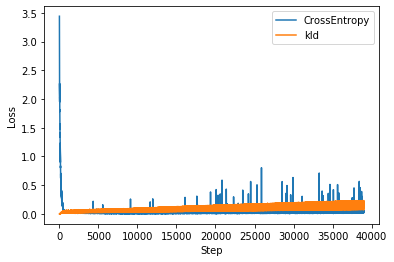

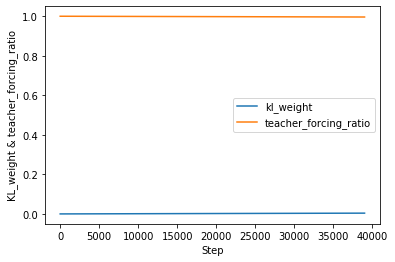

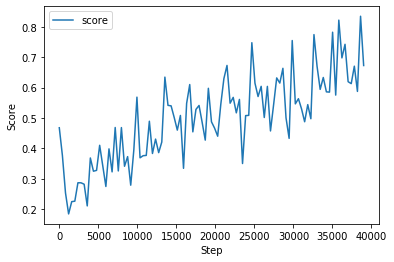

In [11]:
plt.figure()

load = True
if load:
    acc = np.load('loss.npz')
    entropy = acc['entropy']
    kld = acc['kld']
    kl_weight = acc['kl_weight']
    teacher_forcing_ratio = acc['teacher_forcing_ratio']
    score = acc['score']
    
# plt.title("Activation Function comparision(EEGNet)")
plt.ylabel("Loss")
plt.xlabel("Step")
# print(test_loss)
x = np.arange(1, len(entropy)+1)
plt.plot(x, entropy, label="CrossEntropy")
plt.plot(x, kld, label="kld")
plt.legend()
plt.show()
plt.clf()

plt.ylabel("KL_weight & teacher_forcing_ratio")
plt.xlabel("Step")
# print(test_loss)
x = np.arange(1, len(kl_weight)+1)
plt.plot(x, kl_weight, label="kl_weight")
plt.plot(x, teacher_forcing_ratio, label="teacher_forcing_ratio")
# plt.plot(x, test_loss, label="test")
plt.legend()
plt.show()

plt.ylabel("Score")
plt.xlabel("Step")
# print(test_loss)
x = np.linspace(1, len(kl_weight)+1, len(score))
plt.plot(x, score, label="score")
# plt.plot(x, test_loss, label="test")
plt.legend()
plt.show()


In [12]:
def reparaterization_trick(mean, logv):
        std = torch.exp(0.5*logv)
        eps = torch.randn_like(std)
        return  mean + eps * std

for i in range(10):
    encoder_means = torch.randn([1, 1, 32]).to(device)
    encoder_logv = torch.randn([1, 1, 32]).to(device)
    encoder_hidden = reparaterization_trick(encoder_means, encoder_logv)
    encoder_hidden = decoder.latent2hidden(encoder_hidden)
    decoded_indices = decoder.evaluate(context_vector=encoder_hidden)
    results = []
    for indices in decoded_indices:
        results.append(train_loader.vocab.indices_to_sequence(indices))
    print(results[0])

frovers
wonsiding
prattling
propose
hinkering
tiffer
movises
swaste
sales
compose
